# Comparison of CMC-learners and other approaches (illustrative example)

**On Alaa et al. (2023) synthetic data**

In [1]:
# import everyting from data module which is located ../src/data.py
import sys
sys.path.append('..')
from src.datasets.conformal_metalearner_datasets import *

## Create Synthetic Dataset

In [2]:
from sklearn.model_selection import train_test_split

setup_A = {"n":5000, "d": 10, "gamma":1, "alpha": 0.1, "nexps": 1}
setup_B = {"n":5000, "d": 10, "gamma":0, "alpha": 0.1, "nexps": 1}

ds = generate_data(**setup_B)[0]
ds_train, ds_test = train_test_split(ds, test_size=0.6, random_state=42)

In [3]:
W_train = ds_train['T'].to_numpy()
y_train = ds_train['Y'].to_numpy()
y1_train = ds_train['Y1'].to_numpy()
y0_train = ds_train['Y0'].to_numpy()
X_train = ds_train[['X'+str(i) for i in range(1,setup_A["d"]+1)]].to_numpy()
ps_train = ds_train['ps'].to_numpy()
ite_train = y1_train - y0_train

In [4]:
W_test = ds_test['T'].to_numpy()
y_test = ds_test['Y'].to_numpy()
y1_test = ds_test['Y1'].to_numpy()
y0_test = ds_test['Y0'].to_numpy()
X_test = ds_test[['X'+str(i) for i in range(1,setup_A["d"]+1)]].to_numpy()
ps_test = ds_test['ps'].to_numpy()
ite_test = y1_test - y0_test

## Fit Learners

In [5]:
import warnings
from src.mc_conformal_metalearner.mc_conformal_metalearners import Conformal_MC_S_Learner, Conformal_MC_T_Learner, Conformal_MC_X_Learner
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from src.conformal_metalearners.CM_learner import CM_learner
from src.weighted_conformal_prediction.wcp import NaiveWCP

learner = GradientBoostingRegressor

# Initialize the learner
conformal_pseudo_MC_T_Learner = Conformal_MC_T_Learner(
    learner(),
    learner(),
    adaptive_conformal=True,
    pseudo_MC=True,
    MC_samples=100,
)

conformal_MC_T_Learner = Conformal_MC_T_Learner(
    learner(),
    learner(),
    adaptive_conformal=True,
    pseudo_MC=False,
    MC_samples=100,
)

# Fit the learner
print("Fit Pseudo MC T-learner ...")
conformal_pseudo_MC_T_Learner.fit(X_train, y_train, W_train)
print("DONE!")
print("Fit MC T-learner ...")
conformal_MC_T_Learner.fit(X_train, y_train, W_train)
print("DONE!")
conformal_pseudo_MC_S_Learner = Conformal_MC_S_Learner(
            learner(),
            adaptive_conformal=False,
            pseudo_MC=True,
            MC_samples=100,
        )
print("Fit pseudo MC S-learner ...")
with warnings.catch_warnings(action="ignore", category=UserWarning):
    # Suppress warning that is thrown saying that calibration example is too small
    # However, this is a bug in the crepes library in this case
    conformal_pseudo_MC_S_Learner.fit(X_train, y_train, W_train)
print("DONE!")
conformal_MC_S_Learner = Conformal_MC_S_Learner(
    learner(),
    adaptive_conformal=False,
    pseudo_MC=False,
    MC_samples=100,
)
print("Fit MC S-learner ...")
with warnings.catch_warnings(action="ignore", category=UserWarning):
    # Suppress warning that is thrown saying that calibration example is too small
    # However, this is a bug in the crepes library in this case
    conformal_MC_S_Learner.fit(X_train, y_train, W_train)
print("DONE!")
conformal_pseudo_MC_X_Learner = Conformal_MC_X_Learner(
    learner(),
    learner(),
    learner(),
    adaptive_conformal=False,
    pseudo_MC=True,
    MC_samples=100,
)
print("Fit pseudo MC X-learner ...")
# Fit the learner
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    conformal_pseudo_MC_X_Learner.fit(X_train, y_train, W_train)
print("DONE!")
conformal_MC_X_Learner = Conformal_MC_X_Learner(
    learner(),
    learner(),
    learner(),
    adaptive_conformal=False,
    pseudo_MC=False,
    MC_samples=100,
)
print("Fit MC X-learner ...")
# Fit the learner
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    conformal_MC_X_Learner.fit(X_train, y_train, W_train)
naive_WCP = NaiveWCP(
        learner(),
        learner(),
        adaptive_conformal=True)
print("Fit Naive WCP ...")
naive_WCP.fit(X_train, y_train, W_train, ps_train)
print("DONE!")

Fit Pseudo MC T-learner ...
DONE!
Fit MC T-learner ...
DONE!
Fit pseudo MC S-learner ...
DONE!
Fit MC S-learner ...
DONE!
Fit pseudo MC X-learner ...
DONE!
Fit MC X-learner ...
Fit Naive WCP ...
DONE!


## Evaluate learner

In [6]:

from tqdm import tqdm

from src.weighted_conformal_prediction.wcp import NestedWCP
from sklearn.ensemble import GradientBoostingRegressor

alphas = [0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]
coverage_y0 = []
coverage_y1 = []
coverage_pseudo_MC_T_ite = []
coverage_MC_T_ite = []
coverage_pseudo_MC_S_ite = []
coverage_MC_S_ite = []
coverage_pseudo_MC_X_ite = []
coverage_MC_X_ite = []
coverage_CM_ite = []
coverage_naive_ite = []
coverage_exact_ite = []
coverage_inexact_ite = []

int_width_y0 = []
int_width_y1 = []
int_width_pseudo_MC_T = []
int_width_MC_T = []
int_width_pseudo_MC_S = []
int_width_MC_S = []
int_width_pseudo_MC_X = []
int_width_MC_X = []
int_width_CM = []
int_width_naive_ite = []
int_width_exact_ite = []
int_width_inexact_ite = []

rmse_y0 = []
rmse_y1 = []
rmse_pseudo_MC_T_ite, rmse_pseudo_MC_T_ite_conformal_mean = [], []
rmse_MC_T_ite,  rmse_MC_T_ite_conformal_mean = [], []
rmse_pseudo_MC_S_ite, rmse_pseudo_MC_S_ite_conformal_mean = [], []
rmse_MC_S_ite, rmse_MC_S_ite_conformal_mean = [], []
rmse_pseudo_MC_X_ite, rmse_pseudo_MC_X_ite_conformal_mean = [], []
rmse_MC_X_ite, rmse_MC_X_ite_conformal_mean = [], []
rmse_CM_ite = []
rmse_naive_ite = []
rmse_exact_ite = []
rmse_inexact_ite = []

for alpha in tqdm(alphas):
    int_y0_test = conformal_MC_T_Learner.predict_int_y0(X_test, confidence=1-alpha)
    int_y1_test = conformal_MC_T_Learner.predict_int_y1(X_test, confidence=1-alpha)
    int_pseudo_MC_ite_test = conformal_pseudo_MC_T_Learner.predict_int(X_test, confidence=1-alpha)
    int_MC_ite_test = conformal_MC_T_Learner.predict_int(X_test, confidence=1-alpha)
    int_pseudo_MC_S_ite_test = conformal_pseudo_MC_S_Learner.predict_int(X_test, confidence=1-alpha)
    int_MC_S_ite_test = conformal_MC_S_Learner.predict_int(X_test, confidence=1-alpha)
    int_pseudo_MC_X_ite_test = conformal_pseudo_MC_X_Learner.predict_int(X_test, confidence=1-alpha)
    int_MC_X_ite_test = conformal_MC_X_Learner.predict_int(X_test, confidence=1-alpha)
    conformal_Learner = CM_learner(metalearner="DR", alpha=alpha)
    conformal_Learner.fit(X_train, y_train, W_train, ps_train)
    int_CM_ite_test = conformal_Learner.predict_int(X_test)
    int_naive_ite_test = naive_WCP.predict_int(X_test, ps_test, confidence=1-alpha)
    exact_wcp = NestedWCP(
                    learner(),
                    learner(),
                    learner(),
                    adaptive_conformal=True,
                    exact=True)
    exact_wcp.fit(X_train, y_train, W_train, ps_train, confidence=1-alpha)
    int_exact_ite_test = exact_wcp.predict_int(X_test, ps_test)
    inexact_wcp = NestedWCP(
                    learner(),
                    learner(),
                    learner(),
                    adaptive_conformal=True,
                    exact=False)
    inexact_wcp.fit(X_train, y_train, W_train, ps_train, confidence=1-alpha)
    int_inexact_ite_test = inexact_wcp.predict_int(X_test, ps_test)
    coverage_y0.append(np.mean((int_y0_test[:, 0] < y0_test) &  (int_y0_test[:, 1] > y0_test)))
    coverage_y1.append(np.mean((int_y1_test[:, 0] < y1_test) &  (int_y1_test[:, 1] > y1_test)))
    coverage_pseudo_MC_T_ite.append(np.mean((int_pseudo_MC_ite_test[:, 0] < ite_test) &  (int_pseudo_MC_ite_test[:, 1] > ite_test)))
    coverage_MC_T_ite.append(np.mean((int_MC_ite_test[:, 0] < ite_test) &  (int_MC_ite_test[:, 1] > ite_test)))
    coverage_pseudo_MC_S_ite.append(np.mean((int_pseudo_MC_S_ite_test[:, 0] < ite_test) &  (int_pseudo_MC_S_ite_test[:, 1] > ite_test)))
    coverage_MC_S_ite.append(np.mean((int_MC_S_ite_test[:, 0] < ite_test) &  (int_MC_S_ite_test[:, 1] > ite_test)))
    coverage_pseudo_MC_X_ite.append(np.mean((int_pseudo_MC_X_ite_test[:, 0] < ite_test) &  (int_pseudo_MC_X_ite_test[:, 1] > ite_test)))
    coverage_MC_X_ite.append(np.mean((int_MC_X_ite_test[:, 0] < ite_test) &  (int_MC_X_ite_test[:, 1] > ite_test)))
    coverage_CM_ite.append(np.mean((int_CM_ite_test[:, 0] < ite_test) &  (int_CM_ite_test[:, 1] > ite_test)))
    coverage_naive_ite.append(np.mean((int_naive_ite_test[:, 0] < ite_test) &  (int_naive_ite_test[:, 1] > ite_test)))
    coverage_exact_ite.append(np.mean((int_exact_ite_test[:, 0] < ite_test) &  (int_exact_ite_test[:, 1] > ite_test)))
    coverage_inexact_ite.append(np.mean((int_inexact_ite_test[:, 0] < ite_test) &  (int_inexact_ite_test[:, 1] > ite_test)))

    int_width_y0.append(np.diff(int_y0_test).mean())
    int_width_y1.append(np.diff(int_y1_test).mean())
    int_width_pseudo_MC_T.append(np.diff(int_pseudo_MC_ite_test).mean())
    int_width_MC_T.append(np.diff(int_MC_ite_test).mean())
    int_width_pseudo_MC_S.append(np.diff(int_pseudo_MC_S_ite_test).mean())
    int_width_MC_S.append(np.diff(int_MC_S_ite_test).mean())
    int_width_pseudo_MC_X.append(np.diff(int_pseudo_MC_X_ite_test).mean())
    int_width_MC_X.append(np.diff(int_MC_X_ite_test).mean())
    int_width_CM.append(np.diff(int_CM_ite_test).mean())
    int_width_naive_ite.append(np.diff(int_naive_ite_test).mean())
    int_width_exact_ite.append(np.diff(int_exact_ite_test).mean())
    int_width_inexact_ite.append(np.diff(int_inexact_ite_test).mean())

    rmse_y0.append(np.sqrt(np.mean((y0_test - conformal_MC_T_Learner.predict_y0(X_test))**2)))
    rmse_y1.append(np.sqrt(np.mean((y1_test - conformal_MC_T_Learner.predict_y1(X_test))**2)))
    rmse_pseudo_MC_T_ite.append(np.sqrt(np.mean((ite_test - conformal_pseudo_MC_T_Learner.predict(X_test))**2)))
    rmse_MC_T_ite.append(np.sqrt(np.mean((ite_test - conformal_MC_T_Learner.predict(X_test))**2)))
    rmse_pseudo_MC_S_ite.append(np.sqrt(np.mean((ite_test - conformal_pseudo_MC_S_Learner.predict(X_test))**2)))
    rmse_MC_S_ite.append(np.sqrt(np.mean((ite_test - conformal_MC_S_Learner.predict(X_test))**2)))
    rmse_pseudo_MC_X_ite.append(np.sqrt(np.mean((ite_test - conformal_pseudo_MC_X_Learner.predict(X_test))**2)))
    rmse_MC_X_ite.append(np.sqrt(np.mean((ite_test - conformal_MC_X_Learner.predict(X_test))**2)))
    rmse_CM_ite.append(np.sqrt(np.mean((ite_test - conformal_Learner.predict(X_test))**2)))
    rmse_naive_ite.append(np.sqrt(np.mean((ite_test - naive_WCP.predict(X_test))**2)))
    rmse_exact_ite.append(np.sqrt(np.mean((ite_test - exact_wcp.predict(X_test))**2)))
    rmse_inexact_ite.append(np.sqrt(np.mean((ite_test - inexact_wcp.predict(X_test))**2)))

    # conformal_mean
    rmse_pseudo_MC_T_ite_conformal_mean.append(np.sqrt(np.mean((ite_test - conformal_pseudo_MC_T_Learner.predict(X_test, conformal_mean=True))**2)))
    rmse_MC_T_ite_conformal_mean.append(np.sqrt(np.mean((ite_test - conformal_MC_T_Learner.predict(X_test, conformal_mean=True))**2)))
    rmse_pseudo_MC_S_ite_conformal_mean.append(np.sqrt(np.mean((ite_test - conformal_pseudo_MC_S_Learner.predict(X_test, conformal_mean=True))**2)))
    rmse_MC_S_ite_conformal_mean.append(np.sqrt(np.mean((ite_test - conformal_MC_S_Learner.predict(X_test, conformal_mean=True))**2)))
    rmse_pseudo_MC_X_ite_conformal_mean.append(np.sqrt(np.mean((ite_test - conformal_pseudo_MC_X_Learner.predict(X_test, conformal_mean=True))**2)))
    rmse_MC_X_ite_conformal_mean.append(np.sqrt(np.mean((ite_test - conformal_MC_X_Learner.predict(X_test, conformal_mean=True))**2)))

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:45<00:00,  4.54s/it]


Text(0.5, 0, 'Targeted Confidence Level')

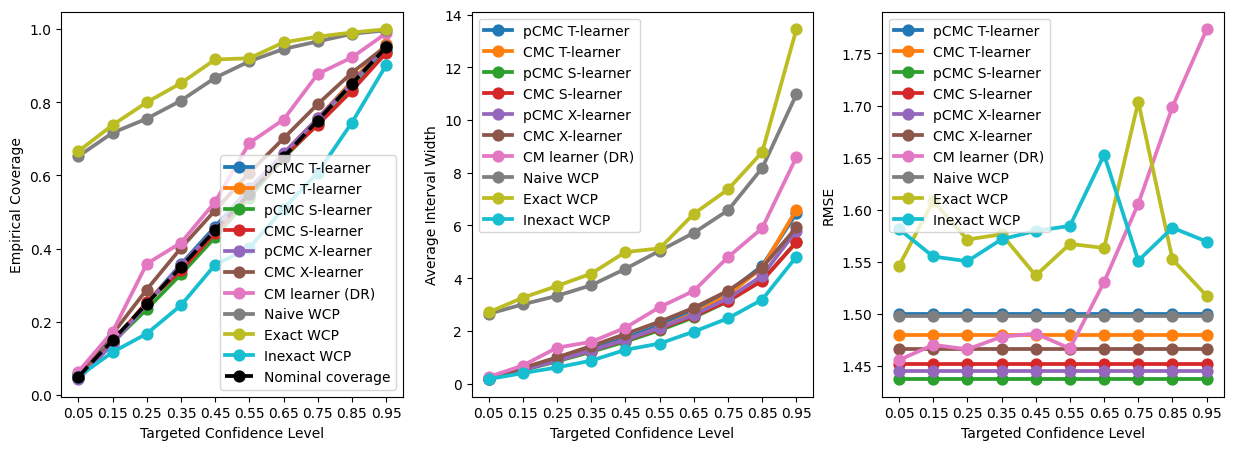

In [7]:

from matplotlib import pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.pointplot(x=[np.round(1-alpha,2) for alpha in alphas], y=coverage_pseudo_MC_T_ite, ax=axs[0], label="pCMC T-learner",
             )
sns.pointplot(x=[np.round(1-alpha,2) for alpha in alphas], y=coverage_MC_T_ite, ax=axs[0], label="CMC T-learner")
sns.pointplot(x=[np.round(1-alpha,2) for alpha in alphas], y=coverage_pseudo_MC_S_ite, ax=axs[0], label="pCMC S-learner")
sns.pointplot(x=[np.round(1-alpha,2) for alpha in alphas], y=coverage_MC_S_ite, ax=axs[0], label="CMC S-learner")
sns.pointplot(x=[np.round(1-alpha,2) for alpha in alphas], y=coverage_pseudo_MC_X_ite, ax=axs[0], label="pCMC X-learner"
                )
sns.pointplot(x=[np.round(1-alpha,2) for alpha in alphas], y=coverage_MC_X_ite, ax=axs[0], label="CMC X-learner")
sns.pointplot(x=[np.round(1-alpha,2) for alpha in alphas], y=coverage_CM_ite, ax=axs[0], label="CM learner (DR)")
sns.pointplot(x=[np.round(1-alpha,2) for alpha in alphas], y=coverage_naive_ite, ax=axs[0], label="Naive WCP")
sns.pointplot(x=[np.round(1-alpha,2) for alpha in alphas], y=coverage_exact_ite, ax=axs[0], label="Exact WCP")
sns.pointplot(x=[np.round(1-alpha,2) for alpha in alphas], y=coverage_inexact_ite, ax=axs[0], label="Inexact WCP")
sns.pointplot(x=[np.round(1-alpha,2) for alpha in alphas], y=[np.round(1-alpha,2) for alpha in alphas], ax=axs[0], label="Nominal coverage",
         linestyle='--', color='black')
axs[0].set_ylabel("Empirical Coverage")
axs[0].set_xlabel("Targeted Confidence Level")

sns.pointplot(x=[np.round(1-alpha,2) for alpha in alphas], y=int_width_pseudo_MC_T, ax=axs[1], label="pCMC T-learner")
sns.pointplot(x=[np.round(1-alpha,2) for alpha in alphas], y=int_width_MC_T, ax=axs[1], label="CMC T-learner")
sns.pointplot(x=[np.round(1-alpha,2) for alpha in alphas], y=int_width_pseudo_MC_S, ax=axs[1], label="pCMC S-learner")
sns.pointplot(x=[np.round(1-alpha,2) for alpha in alphas], y=int_width_MC_S, ax=axs[1], label="CMC S-learner")
sns.pointplot(x=[np.round(1-alpha,2) for alpha in alphas], y=int_width_pseudo_MC_X, ax=axs[1], label="pCMC X-learner")
sns.pointplot(x=[np.round(1-alpha,2) for alpha in alphas], y=int_width_MC_X, ax=axs[1], label="CMC X-learner")
sns.pointplot(x=[np.round(1-alpha,2) for alpha in alphas], y=int_width_CM, ax=axs[1], label="CM learner (DR)")
sns.pointplot(x=[np.round(1-alpha,2) for alpha in alphas], y=int_width_naive_ite, ax=axs[1], label="Naive WCP")
sns.pointplot(x=[np.round(1-alpha,2) for alpha in alphas], y=int_width_exact_ite, ax=axs[1], label="Exact WCP")
sns.pointplot(x=[np.round(1-alpha,2) for alpha in alphas], y=int_width_inexact_ite, ax=axs[1], label="Inexact WCP")
axs[1].set_ylabel("Average Interval Width")
axs[1].set_xlabel("Targeted Confidence Level")

sns.pointplot(x=[np.round(1-alpha,2) for alpha in alphas], y=rmse_pseudo_MC_T_ite, ax=axs[2], label="pCMC T-learner")
sns.pointplot(x=[np.round(1-alpha,2) for alpha in alphas], y=rmse_MC_T_ite, ax=axs[2], label="CMC T-learner")
sns.pointplot(x=[np.round(1-alpha,2) for alpha in alphas], y=rmse_pseudo_MC_S_ite, ax=axs[2], label="pCMC S-learner")
sns.pointplot(x=[np.round(1-alpha,2) for alpha in alphas], y=rmse_MC_S_ite, ax=axs[2], label="CMC S-learner")
sns.pointplot(x=[np.round(1-alpha,2) for alpha in alphas], y=rmse_pseudo_MC_X_ite, ax=axs[2], label="pCMC X-learner")
sns.pointplot(x=[np.round(1-alpha,2) for alpha in alphas], y=rmse_MC_X_ite, ax=axs[2], label="CMC X-learner")
sns.pointplot(x=[np.round(1-alpha,2) for alpha in alphas], y=rmse_CM_ite, ax=axs[2], label="CM learner (DR)")
sns.pointplot(x=[np.round(1-alpha,2) for alpha in alphas], y=rmse_naive_ite, ax=axs[2], label="Naive WCP")
sns.pointplot(x=[np.round(1-alpha,2) for alpha in alphas], y=rmse_exact_ite, ax=axs[2], label="Exact WCP")
sns.pointplot(x=[np.round(1-alpha,2) for alpha in alphas], y=rmse_inexact_ite, ax=axs[2], label="Inexact WCP")
axs[2].set_ylabel("RMSE")
axs[2].set_xlabel("Targeted Confidence Level")

In [8]:
print(f"Difference between regulare mean and conformal mean (pCMC T-learner): {np.mean(rmse_pseudo_MC_T_ite) - np.mean(rmse_pseudo_MC_T_ite_conformal_mean)}")
print(f"Difference between regulare mean and conformal mean (CMC T-learner): {np.mean(rmse_MC_T_ite) - np.mean(rmse_MC_T_ite_conformal_mean)}")
print(f"Difference between regulare mean and conformal mean (pCMC S-learner): {np.mean(rmse_pseudo_MC_S_ite) - np.mean(rmse_pseudo_MC_S_ite_conformal_mean)}")
print(f"Difference between regulare mean and conformal mean (CMC S-learner): {np.mean(rmse_MC_S_ite) - np.mean(rmse_MC_S_ite_conformal_mean)}")
print(f"Difference between regulare mean and conformal mean (pCMC X-learner): {np.mean(rmse_pseudo_MC_X_ite) - np.mean(rmse_pseudo_MC_X_ite_conformal_mean)}")
print(f"Difference between regulare mean and conformal mean (CMC X-learner): {np.mean(rmse_MC_X_ite) - np.mean(rmse_MC_X_ite_conformal_mean)}")

Difference between regulare mean and conformal mean (pCMC T-learner): -0.005545649341305525
Difference between regulare mean and conformal mean (CMC T-learner): -0.000989926252834561
Difference between regulare mean and conformal mean (pCMC S-learner): -0.006905132906113831
Difference between regulare mean and conformal mean (CMC S-learner): 0.00045459832033567515
Difference between regulare mean and conformal mean (pCMC X-learner): -0.0035340658941840353
Difference between regulare mean and conformal mean (CMC X-learner): 0.0006794113360160114
